In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
print(f"Python: {sys.executable}")

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("✅ All imports successful!")
print(f"NetworkX version: {nx.__version__}")
print(f"Pandas version: {pd.__version__}")

Python: c:\Users\ritac\anaconda3\envs\venv\python.exe
✅ All imports successful!
NetworkX version: 3.4.2
Pandas version: 2.3.3


In [3]:
# 1. Load the data
DATA_FILEPATH = '../data/'
# commented out for A/B testing of enhanced KG
# nodes_df = pd.read_csv(DATA_FILEPATH + 'kg_nodes.csv')
# edges_df = pd.read_csv(DATA_FILEPATH + 'kg_edges.csv')
KG_NODES_FILE = 'kg_nodes_final.csv'
KG_EDGES_FILE = 'kg_edges_final.csv'

nodes_df = pd.read_csv(DATA_FILEPATH + KG_NODES_FILE)
edges_df = pd.read_csv(DATA_FILEPATH + KG_EDGES_FILE)

# Pre-processing: Identify Node Types for filtering
node_type_map = nodes_df.set_index('id')['type'].to_dict()

In [4]:
edges_df.shape

(1438, 7)

In [5]:
all(edges_df['source'] == 'Pralsetinib')

False

In [6]:
edges_df = edges_df.assign(target_type=edges_df['target'].map(node_type_map))
edges_df['target_type'].value_counts()

target_type
Disease          1190
Chemical          100
Gene               99
Gene/Protein       20
Adverse Event      15
Protein             7
Pathway             7
Name: count, dtype: int64

Every edge involves Pralsetinib as its source

In [7]:
# 2. Layering the Edges
# Path A/B: Mechanistic (Drug -> Protein -> Disease/AE)
# Path C: Clinical Shortcut (Drug -> Disease/AE)
is_clinical_shortcut = (
    (edges_df['source'] == 'Pralsetinib') & 
    (edges_df['target'].map(node_type_map).isin(['Adverse Event', 'Disease']))
)

clinical_edges = edges_df[is_clinical_shortcut]
mechanistic_edges = edges_df[~is_clinical_shortcut]

print(f"Total Edges: {len(edges_df)}")
print(f"Clinical Shortcuts Found: {len(clinical_edges)}")
print(f"Mechanistic Edges Remaining: {len(mechanistic_edges)}")

Total Edges: 1438
Clinical Shortcuts Found: 0
Mechanistic Edges Remaining: 1438


In [8]:
mechanistic_edges['target_type'].value_counts()

target_type
Disease          1190
Chemical          100
Gene               99
Gene/Protein       20
Adverse Event      15
Protein             7
Pathway             7
Name: count, dtype: int64

In [9]:
clinical_edges['target_type'].value_counts()

Series([], Name: count, dtype: int64)

In [10]:
# 3. Graph Construction (Mechanistic Only)
G_mech = nx.from_pandas_edgelist(
    mechanistic_edges, 
    source='source', 
    target='target', 
    edge_attr=['relation', 'value'], 
    create_using=nx.DiGraph()
)

In [11]:
# 4. Mechanistic EDA: Degree Centrality
# We want to see which proteins are 'Hubs' once the shortcuts are gone
centrality = nx.degree_centrality(G_mech)
hub_df = pd.DataFrame(centrality.items(), columns=['Node', 'Centrality']).sort_values(by='Centrality', ascending=False)

print("\n--- Top Mechanistic Hubs (Proteins) ---")
print(hub_df[hub_df['Node'].map(node_type_map) == 'Protein'].head(5))


--- Top Mechanistic Hubs (Proteins) ---
                                                Node  Centrality
7        KDR - kinase insert domain receptor (human)    0.523452
4               Tyrosine-protein kinase JAK2 (human)    0.521576
2    CCDC6 - coiled-coil domain containing 6 (human)    0.437148
5           KIF5B - kinesin family member 5B (human)    0.403377
6  FLT3 - fms related receptor tyrosine kinase 3 ...    0.386492


In [12]:
# 5. The "Reasoning" Test: Finding the Bridge
def find_mechanism(ae_node):
    print(f"\nSearching for molecular mechanism for: {ae_node}")
    try:
        # Find all paths from Pralsetinib to the AE in the mechanistic-only graph
        paths = list(nx.all_simple_paths(G_mech, source='Pralsetinib', target=ae_node, cutoff=2))
        if paths:
            for path in paths:
                # Get the IC50 of the first hop (Drug -> Protein)
                target_protein = path[1]
                potency = mechanistic_edges[
                    (mechanistic_edges['source'] == 'Pralsetinib') & 
                    (mechanistic_edges['target'] == target_protein)
                ]['value'].values[0]
                
                print(f" SUCCESS: {path[0]} --({potency}nM)--> {path[1]} --[assoc]--> {path[2]}")
        else:
            print(f" FAILED: No protein bridge found for {ae_node} in bioassay data.")
    except Exception as e:
        print(f" ERROR: Node {ae_node} not found in mechanistic graph.")

# Run the test
find_mechanism('Hypertension')
find_mechanism('Neutropenia')


Searching for molecular mechanism for: Hypertension
 SUCCESS: Pralsetinib --(0.4nM)--> CCDC6 - coiled-coil domain containing 6 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(2.0nM)--> Tyrosine-protein kinase JAK2 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(4.0nM)--> KIF5B - kinesin family member 5B (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(6.5nM)--> FLT3 - fms related receptor tyrosine kinase 3 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(35.0nM)--> KDR - kinase insert domain receptor (human) --[assoc]--> Hypertension

Searching for molecular mechanism for: Neutropenia
 SUCCESS: Pralsetinib --(0.4nM)--> CCDC6 - coiled-coil domain containing 6 (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(2.0nM)--> Tyrosine-protein kinase JAK2 (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(4.0nM)--> KIF5B - kinesin family member 5B (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(6.5nM)--> FLT3 - fms related recep

C:\Users\ritac\AppData\Local\Temp\ipykernel_19584\3331898350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=nodes_df, x='type', palette='magma')


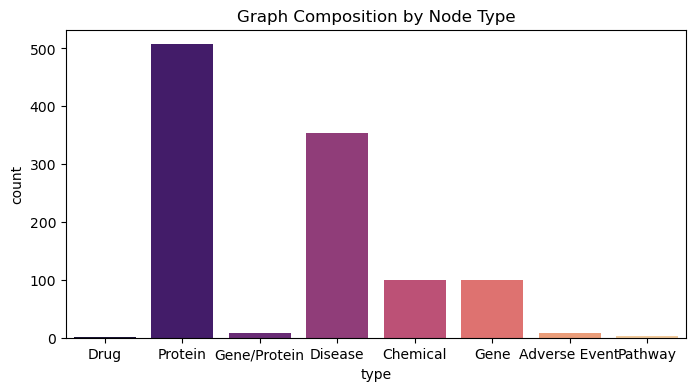

In [13]:
# 6. Visualization of Node Types (Scannable EDA)
plt.figure(figsize=(8, 4))
sns.countplot(data=nodes_df, x='type', palette='magma')
plt.title('Graph Composition by Node Type')
plt.show()

In [14]:
# 1. Component Analysis (The 'Island' Count)
# In G_mech, we expect many components because the Protein -> AE links are missing
components = list(nx.weakly_connected_components(G_mech))
component_sizes = [len(c) for c in components]

print(f"--- Global Connectivity (G_mech) ---")
print(f"Number of Disconnected Islands: {len(components)}")
print(f"Size of Largest Biological Cluster: {max(component_sizes)}")
print(f"Number of Isolated Nodes: {component_sizes.count(1)}")

# 2. Network Density & Efficiency
# Density tells us how "saturated" our bioassay data is.
print(f"\nGraph Density: {nx.density(G_mech):.6f}")

# 3. Node-Type Specific Connectivity
# We check which node types are the most 'lonely' (degree 0 or 1)
degree_dict = dict(G_mech.degree())
nodes_df['degree'] = nodes_df['id'].map(degree_dict).fillna(0)
lonely_nodes = nodes_df[nodes_df['degree'] <= 1].groupby('type').size()

print("\n--- Nodes with 1 or 0 connections in G_mech ---")
print(lonely_nodes)

--- Global Connectivity (G_mech) ---
Number of Disconnected Islands: 1
Size of Largest Biological Cluster: 534
Number of Isolated Nodes: 0

Graph Density: 0.005049

--- Nodes with 1 or 0 connections in G_mech ---
type
Adverse Event      5
Chemical         100
Disease           84
Gene              99
Gene/Protein       2
Protein          500
dtype: int64


In [15]:
# 7. A/B Comparison: Baseline vs V2 vs Enriched
FILES = {
    # 'baseline': ('kg_nodes.csv', 'kg_edges.csv'),
    'v2': ('kg_nodes_v2.csv', 'kg_edges_v2.csv'),
    'enriched': (KG_NODES_FILE, KG_EDGES_FILE),
}


def build_graph_summary(nodes_path, edges_path, mechanistic_only=False):
    nodes = pd.read_csv(DATA_FILEPATH + nodes_path)
    edges = pd.read_csv(DATA_FILEPATH + edges_path)
    node_type_map = nodes.set_index('id')['type'].to_dict()

    if mechanistic_only:
        is_shortcut = (
            (edges['source'] == 'Pralsetinib') &
            (edges['target'].map(node_type_map).isin(['Adverse Event', 'Disease']))
        )
        edges = edges[~is_shortcut]

    G = nx.from_pandas_edgelist(
        edges,
        source='source',
        target='target',
        create_using=nx.DiGraph()
    )
    degree_dict = dict(G.degree())
    nodes['degree'] = nodes['id'].map(degree_dict).fillna(0)
    summary = {
        'nodes': len(nodes),
        'edges': len(edges),
        'density': nx.density(G),
        'avg_degree': nodes['degree'].mean(),
        'pct_degree_leq_1': (nodes['degree'] <= 1).mean(),
        'components': len(list(nx.weakly_connected_components(G)))
    }
    return pd.Series(summary)

summaries = {
    label: build_graph_summary(nodes_file, edges_file)
    for label, (nodes_file, edges_file) in FILES.items()
}
comparison = pd.DataFrame(summaries)
comparison['delta_enriched'] = comparison['enriched'] - comparison['v2']

comparison = comparison.reindex(
    ['nodes', 'edges', 'density', 'avg_degree', 'pct_degree_leq_1', 'components']
)
comparison = comparison.round(6)

print("--- KG Comparison (Baseline vs Enriched) ---")
print(comparison)

print("\n--- File Inputs ---")
for label, (nodes_file, edges_file) in FILES.items():
    print(f"{label}: {nodes_file}, {edges_file}")

--- KG Comparison (Baseline vs Enriched) ---
                          v2     enriched  delta_enriched
nodes             285.000000  1081.000000      796.000000
edges             375.000000  1438.000000     1063.000000
density             0.003509     0.005049        0.001540
avg_degree          1.992982     2.658649        0.665667
pct_degree_leq_1    0.996491     0.730805       -0.265686
components          1.000000     1.000000        0.000000

--- File Inputs ---
v2: kg_nodes_v2.csv, kg_edges_v2.csv
enriched: kg_nodes_final.csv, kg_edges_final.csv


In [16]:
# 7b. A/B Comparison (Mechanistic Only)
MECH_FILES = FILES

mech_summaries = {
    label: build_graph_summary(nodes_file, edges_file, mechanistic_only=True)
    for label, (nodes_file, edges_file) in MECH_FILES.items()
}
mech_comparison = pd.DataFrame(mech_summaries)
mech_comparison['delta_enriched'] = mech_comparison['enriched'] - mech_comparison['v2']

mech_comparison = mech_comparison.reindex(
    ['nodes', 'edges', 'density', 'avg_degree', 'pct_degree_leq_1', 'components']
).round(6)

print("--- KG Comparison (Mechanistic Only) ---")
print(mech_comparison)

print("\n--- File Inputs ---")
for label, (nodes_file, edges_file) in MECH_FILES.items():
    print(f"{label}: {nodes_file}, {edges_file}")

--- KG Comparison (Mechanistic Only) ---
                          v2     enriched  delta_enriched
nodes             285.000000  1081.000000      796.000000
edges             244.000000  1438.000000     1194.000000
density             0.004651     0.005049        0.000398
avg_degree          1.501754     2.658649        1.156895
pct_degree_leq_1    0.996491     0.730805       -0.265686
components          1.000000     1.000000        0.000000

--- File Inputs ---
v2: kg_nodes_v2.csv, kg_edges_v2.csv
enriched: kg_nodes_final.csv, kg_edges_final.csv


In [17]:
# 7c. Mechanistic edge type breakdown (current KG)
mech_nodes = pd.read_csv(DATA_FILEPATH + KG_NODES_FILE)
mech_edges_all = pd.read_csv(DATA_FILEPATH + KG_EDGES_FILE)
mech_node_type_map = mech_nodes.set_index('id')['type'].to_dict()
mech_is_shortcut = (
    (mech_edges_all['source'] == 'Pralsetinib') &
    (mech_edges_all['target'].map(mech_node_type_map).isin(['Adverse Event', 'Disease']))
)
mech_edges_filtered = mech_edges_all[~mech_is_shortcut]

print("--- Mechanistic Edge Type Counts (current KG) ---")
print(mech_edges_filtered['relation'].value_counts())

--- Mechanistic Edge Type Counts (current KG) ---
relation
associated_with            1205
co_occurs_with_chemical     100
co_occurs_with_gene          99
inhibits                     13
interacts_with               11
involved_in                   7
targets                       3
Name: count, dtype: int64


In [18]:
# Filter for nodes where degree is greater than 1
connected_nodes_df = nodes_df[nodes_df['degree'] > 1]

print(f"Number of nodes with 2+ connections: {len(connected_nodes_df)}")
print(connected_nodes_df[['id', 'type', 'degree']].head())

Number of nodes with 2+ connections: 291
                                                  id     type  degree
0                                        Pralsetinib     Drug   214.0
1                   RET - ret proto-oncogene (human)  Protein     4.0
2    CCDC6 - coiled-coil domain containing 6 (human)  Protein   233.0
3  Proto-oncogene tyrosine-protein kinase recepto...  Protein     4.0
4               Tyrosine-protein kinase JAK2 (human)  Protein   278.0


In [19]:
# 1. Identify all weakly connected components (clusters)
# This includes single isolated nodes as components of size 1
components = list(nx.weakly_connected_components(G_mech))

# 2. Calculate the size of each cluster
component_sizes = [len(c) for c in components]

# 3. Create a summary for easy reading
size_summary = pd.Series(component_sizes).value_counts().sort_index(ascending=False)

print(f"Total number of clusters: {len(components)}")
print("\nCluster Size Breakdown:")
print("Size | Count")
print("-------------")
for size, count in size_summary.items():
    print(f"{size:<4} | {count}")

# Optional: List the nodes in the largest cluster
largest_cluster = max(components, key=len)
print(f"\nLargest cluster contains {len(largest_cluster)} nodes.")

Total number of clusters: 1

Cluster Size Breakdown:
Size | Count
-------------
534  | 1

Largest cluster contains 534 nodes.


In [20]:
# Protein Analysis - Identifying the Bottleneck
print("\n=== PROTEIN ANALYSIS ===\n")

# Extract protein nodes
protein_nodes = nodes_df[nodes_df['type'].isin(['Protein', 'Gene/Protein'])].copy()
print(f"Total Proteins in KG: {len(protein_nodes)}\n")

# Identify known targets vs candidates
known_targets = edges_df[
    (edges_df['source'] == 'Pralsetinib') & 
    (edges_df['relation'] == 'inhibits')
]['target'].unique()

print(f"Known Targets (with 'inhibits' edge): {len(known_targets)}")
inhibits_with_ic50 = edges_df[
    (edges_df['source'] == 'Pralsetinib') & 
    (edges_df['relation'] == 'inhibits')
][['target', 'value']].sort_values('value')
print(inhibits_with_ic50.to_string(index=False))

# Candidate proteins (no inhibits edge)
candidates = protein_nodes[~protein_nodes['id'].isin(known_targets)]['id'].tolist()
print(f"\nCandidate Proteins (no 'inhibits' edge): {len(candidates)}")
if candidates:
    for cand in sorted(candidates):
        print(f"  • {cand}")

print(f"\n{len(candidates)} novel candidates for GNN prediction\n")


=== PROTEIN ANALYSIS ===

Total Proteins in KG: 516

Known Targets (with 'inhibits' edge): 13
                                                     target  value
                           RET - ret proto-oncogene (human)    0.3
            CCDC6 - coiled-coil domain containing 6 (human)    0.4
Proto-oncogene tyrosine-protein kinase receptor Ret (human)    0.4
                       Tyrosine-protein kinase JAK2 (human)    2.0
                KDR - kinase insert domain receptor (human)   35.0
                   KIF5B - kinesin family member 5B (human)    4.0
      FLT3 - fms related receptor tyrosine kinase 3 (human)    6.5
                                                        RET Active
                                                      PTK2B Active
                                                      KIF5B Active
                                                        KDR Active
                                                       DRD2 Active
                                  


=== IC50 DISTRIBUTION ===

IC50 Statistics:
  Count: 7
  Mean: 6.94 nM
  Median: 2.00 nM
  Range: 0.30 - 35.00 nM



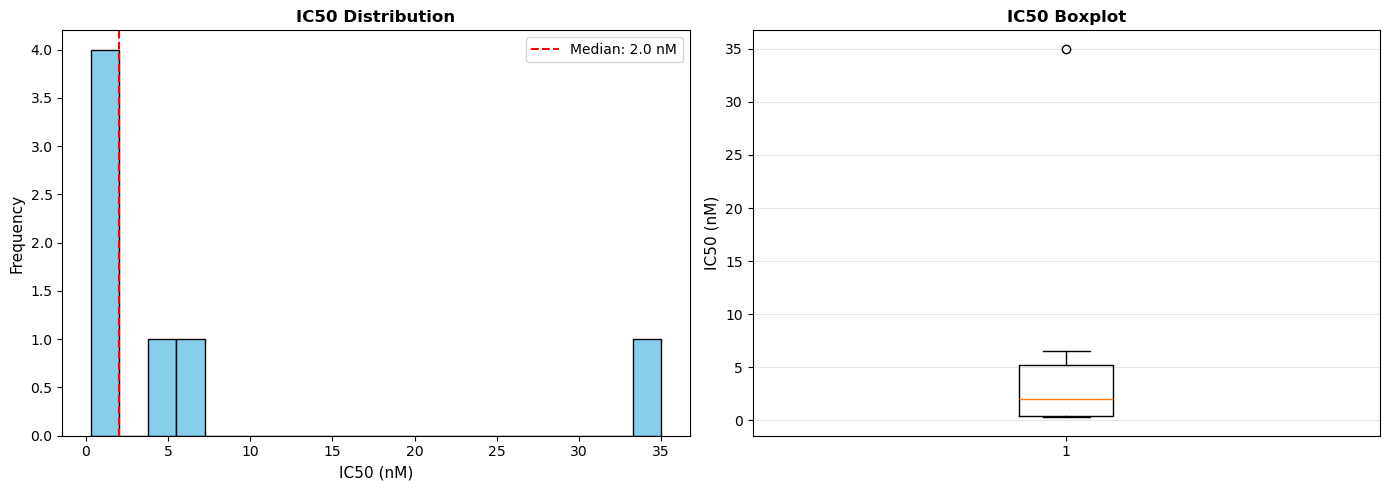

Top 5 Most Potent Targets:
  RET - ret proto-oncogene (human): 0.30 nM
  CCDC6 - coiled-coil domain containing 6 (human): 0.40 nM
  Proto-oncogene tyrosine-protein kinase receptor Ret (human): 0.40 nM
  Tyrosine-protein kinase JAK2 (human): 2.00 nM
  KIF5B - kinesin family member 5B (human): 4.00 nM


In [21]:
# IC50 Distribution Analysis
print("\n=== IC50 DISTRIBUTION ===\n")

# Extract inhibits edges with IC50 values
inhibits_edges = edges_df[edges_df['relation'] == 'inhibits'].copy()
inhibits_edges['value'] = pd.to_numeric(inhibits_edges['value'], errors='coerce')
inhibits_edges = inhibits_edges.dropna(subset=['value'])

print(f"IC50 Statistics:")
print(f"  Count: {len(inhibits_edges)}")
print(f"  Mean: {inhibits_edges['value'].mean():.2f} nM")
print(f"  Median: {inhibits_edges['value'].median():.2f} nM")
print(f"  Range: {inhibits_edges['value'].min():.2f} - {inhibits_edges['value'].max():.2f} nM\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(inhibits_edges['value'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_xlabel('IC50 (nM)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('IC50 Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(inhibits_edges['value'].median(), color='red', linestyle='--', 
                label=f'Median: {inhibits_edges["value"].median():.1f} nM')
axes[0].legend()

axes[1].boxplot(inhibits_edges['value'], vert=True)
axes[1].set_ylabel('IC50 (nM)', fontsize=11)
axes[1].set_title('IC50 Boxplot', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Top targets
print("Top 5 Most Potent Targets:")
top_potent = inhibits_edges.nsmallest(5, 'value')[['target', 'value']]
for idx, row in top_potent.iterrows():
    print(f"  {row['target']}: {row['value']:.2f} nM")


=== OUTCOME COVERAGE ===

Proteins with outcome data: 5/516 (1.0%)
Unique outcomes (Disease/AE): 315

Top Proteins by Outcome Associations:
  KDR - kinase insert domain receptor (human): 278
  Tyrosine-protein kinase JAK2 (human): 277
  CCDC6 - coiled-coil domain containing 6 (human): 232
  KIF5B - kinesin family member 5B (human): 214
  FLT3 - fms related receptor tyrosine kinase 3 (human): 204

Proteins WITHOUT Outcome Data: 511


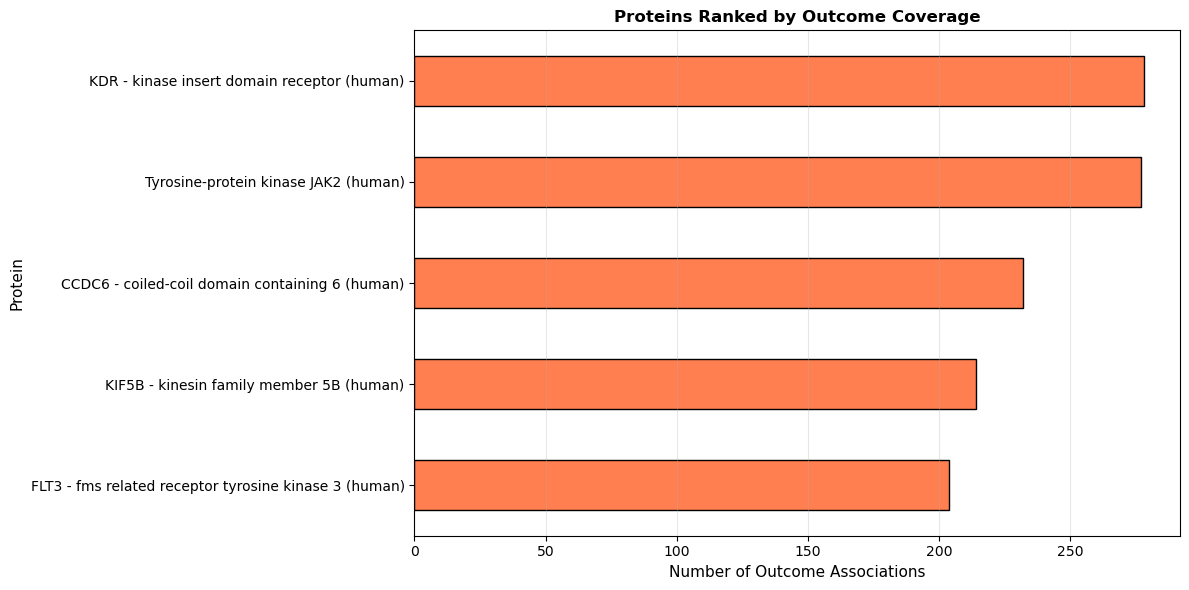

In [22]:
# Outcome Coverage Analysis
print("\n=== OUTCOME COVERAGE ===\n")

# Extract protein -> outcome edges
outcome_edges = edges_df[edges_df['relation'] == 'associated_with'].copy()
proteins_with_outcomes = outcome_edges['source'].unique()
unique_outcomes = outcome_edges['target'].unique()

print(f"Proteins with outcome data: {len(proteins_with_outcomes)}/{len(protein_nodes)} ({len(proteins_with_outcomes)/len(protein_nodes)*100:.1f}%)")
print(f"Unique outcomes (Disease/AE): {len(unique_outcomes)}\n")

# Outcome distribution per protein
outcome_counts = outcome_edges.groupby('source').size().sort_values(ascending=False)

print("Top Proteins by Outcome Associations:")
for protein, count in outcome_counts.head(10).items():
    print(f"  {protein}: {count}")

# Proteins without outcome data
proteins_without_outcomes = set(protein_nodes['id']) - set(proteins_with_outcomes)
print(f"\nProteins WITHOUT Outcome Data: {len(proteins_without_outcomes)}")

# Visualization
plt.figure(figsize=(12, 6))
outcome_counts.head(15).plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Outcome Associations', fontsize=11)
plt.ylabel('Protein', fontsize=11)
plt.title('Proteins Ranked by Outcome Coverage', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Gap Analysis
print("\n=== GAP ANALYSIS ===\n")

print("Current State:")
print(f"  Total proteins: {len(protein_nodes)}")
print(f"  Known targets: {len(known_targets)}")
print(f"  Candidates: {len(candidates)}")
print(f"  With IC50 data: {len(inhibits_edges)}")
print(f"  With outcome data: {len(proteins_with_outcomes)}\n")


=== GAP ANALYSIS ===

Current State:
  Total proteins: 516
  Known targets: 13
  Candidates: 503
  With IC50 data: 7
  With outcome data: 5

